In [1]:
from torchvision.datasets import Cityscapes
from torchvision import transforms
from torch.utils.data import DataLoader, Subset

image_size = (64, 128)
root_dir = "datasets/cityscapes"

input_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
])

target_transform = transforms.Compose([
    transforms.Resize(
        image_size,
        interpolation=transforms.InterpolationMode.NEAREST
    )
])


full_train_dataset = Cityscapes(
    root=root_dir,
    split='train',
    mode='fine',
    target_type='semantic',
    transform=input_transform,
    target_transform=target_transform,
)

full_val_dataset = Cityscapes(
    root=root_dir,
    split='val',
    mode='fine',
    target_type='semantic',
    transform=input_transform,
    target_transform=target_transform,
)

In [2]:
from utils.Cityscapes.CityscapesWrapper import CityscapesWrapper

train_samples = 800
val_samples = 200

train_subset = CityscapesWrapper(
    Subset(
        full_train_dataset,
        range(train_samples)
    ),
    target_transform=target_transform
)
val_subset = CityscapesWrapper(
    Subset(
        full_val_dataset,
        range(val_samples)
    ),
    target_transform=target_transform
)

train_loader = DataLoader(
    train_subset,
    batch_size=4,
    shuffle=True,
    num_workers=0
)
val_loader = DataLoader(
    val_subset,
    batch_size=4,
    shuffle=False,
    num_workers=0
)

In [3]:
from utils.Cityscapes.UNetTorchCityscapes import UNet
import torch.optim as optim
import torch.nn as nn

device = "mps"
model = UNet(
    in_channels=3,
    out_channels=34
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    model.parameters(),
    lr=1e-3
)

In [4]:
from utils.Cityscapes.CityscapesTrainingUtils import train_one_epoch_cityscapes, validate_cityscapes

train_losses = []
val_losses = []

num_epochs = 100
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    train_loss = train_one_epoch_cityscapes(model, train_loader, optimizer, criterion)
    val_loss = validate_cityscapes(model, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")


Epoch 1/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  3.93it/s]


Train Loss: 2.0271 | Val Loss: 1.2674

Epoch 2/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  3.92it/s]


Train Loss: 1.2209 | Val Loss: 1.1143

Epoch 3/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.02it/s]


Train Loss: 1.0871 | Val Loss: 0.9762

Epoch 4/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  3.99it/s]


Train Loss: 0.9970 | Val Loss: 0.9506

Epoch 5/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.00it/s]


Train Loss: 0.9511 | Val Loss: 0.8914

Epoch 6/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.00it/s]


Train Loss: 0.9248 | Val Loss: 0.8869

Epoch 7/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.00it/s]


Train Loss: 0.8999 | Val Loss: 0.8520

Epoch 8/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.01it/s]


Train Loss: 0.8758 | Val Loss: 0.8631

Epoch 9/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.02it/s]


Train Loss: 0.8321 | Val Loss: 0.8460

Epoch 10/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.00it/s]


Train Loss: 0.8149 | Val Loss: 0.7967

Epoch 11/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.02it/s]


Train Loss: 0.7970 | Val Loss: 0.8462

Epoch 12/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.03it/s]


Train Loss: 0.7724 | Val Loss: 0.7609

Epoch 13/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.02it/s]


Train Loss: 0.7595 | Val Loss: 0.7529

Epoch 14/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.01it/s]


Train Loss: 0.7550 | Val Loss: 0.7449

Epoch 15/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.00it/s]


Train Loss: 0.7296 | Val Loss: 0.7386

Epoch 16/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.01it/s]


Train Loss: 0.7221 | Val Loss: 0.7293

Epoch 17/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.01it/s]


Train Loss: 0.7087 | Val Loss: 0.7597

Epoch 18/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.02it/s]


Train Loss: 0.6947 | Val Loss: 0.7164

Epoch 19/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.01it/s]


Train Loss: 0.6735 | Val Loss: 0.7148

Epoch 20/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.00it/s]


Train Loss: 0.6594 | Val Loss: 0.7141

Epoch 21/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.01it/s]


Train Loss: 0.6521 | Val Loss: 0.7242

Epoch 22/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.02it/s]


Train Loss: 0.6313 | Val Loss: 0.6878

Epoch 23/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.01it/s]


Train Loss: 0.6242 | Val Loss: 0.6916

Epoch 24/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.02it/s]


Train Loss: 0.6019 | Val Loss: 0.6931

Epoch 25/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.02it/s]


Train Loss: 0.6024 | Val Loss: 0.6810

Epoch 26/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.02it/s]


Train Loss: 0.5876 | Val Loss: 0.6608

Epoch 27/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.03it/s]


Train Loss: 0.5674 | Val Loss: 0.6493

Epoch 28/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.02it/s]


Train Loss: 0.5569 | Val Loss: 0.6530

Epoch 29/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  3.96it/s]


Train Loss: 0.5370 | Val Loss: 0.6463

Epoch 30/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.01it/s]


Train Loss: 0.5356 | Val Loss: 0.6573

Epoch 31/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.02it/s]


Train Loss: 0.5113 | Val Loss: 0.6910

Epoch 32/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  3.97it/s]


Train Loss: 0.4944 | Val Loss: 0.6676

Epoch 33/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.02it/s]


Train Loss: 0.4839 | Val Loss: 0.6865

Epoch 34/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.00it/s]


Train Loss: 0.5000 | Val Loss: 0.6980

Epoch 35/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.01it/s]


Train Loss: 0.4656 | Val Loss: 0.7030

Epoch 36/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.01it/s]


Train Loss: 0.4548 | Val Loss: 0.6873

Epoch 37/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.01it/s]


Train Loss: 0.4398 | Val Loss: 0.6925

Epoch 38/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.01it/s]


Train Loss: 0.4510 | Val Loss: 0.6918

Epoch 39/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.01it/s]


Train Loss: 0.4393 | Val Loss: 0.6647

Epoch 40/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.01it/s]


Train Loss: 0.4202 | Val Loss: 0.7350

Epoch 41/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.02it/s]


Train Loss: 0.4134 | Val Loss: 0.7192

Epoch 42/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.00it/s]


Train Loss: 0.4218 | Val Loss: 0.7402

Epoch 43/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.01it/s]


Train Loss: 0.3853 | Val Loss: 0.6998

Epoch 44/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.01it/s]


Train Loss: 0.3600 | Val Loss: 0.7367

Epoch 45/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.01it/s]


Train Loss: 0.3614 | Val Loss: 0.6729

Epoch 46/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.02it/s]


Train Loss: 0.3777 | Val Loss: 0.6971

Epoch 47/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.00it/s]


Train Loss: 0.3926 | Val Loss: 0.7042

Epoch 48/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.00it/s]


Train Loss: 0.3516 | Val Loss: 0.7351

Epoch 49/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.03it/s]


Train Loss: 0.3297 | Val Loss: 0.7869

Epoch 50/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.03it/s]


Train Loss: 0.3170 | Val Loss: 0.7527

Epoch 51/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.02it/s]


Train Loss: 0.3050 | Val Loss: 0.7461

Epoch 52/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.02it/s]


Train Loss: 0.3080 | Val Loss: 0.7349

Epoch 53/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.02it/s]


Train Loss: 0.4208 | Val Loss: 0.6850

Epoch 54/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.02it/s]


Train Loss: 0.3405 | Val Loss: 0.7149

Epoch 55/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.00it/s]


Train Loss: 0.2877 | Val Loss: 0.7500

Epoch 56/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.02it/s]


Train Loss: 0.2690 | Val Loss: 0.7642

Epoch 57/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.02it/s]


Train Loss: 0.2580 | Val Loss: 0.7766

Epoch 58/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.02it/s]


Train Loss: 0.2545 | Val Loss: 0.7956

Epoch 59/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.03it/s]


Train Loss: 0.2485 | Val Loss: 0.8131

Epoch 60/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.02it/s]


Train Loss: 0.2450 | Val Loss: 0.8390

Epoch 61/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.02it/s]


Train Loss: 0.2452 | Val Loss: 0.8269

Epoch 62/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.02it/s]


Train Loss: 0.3217 | Val Loss: 0.7594

Epoch 63/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.01it/s]


Train Loss: 0.3500 | Val Loss: 0.7718

Epoch 64/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.02it/s]


Train Loss: 0.2812 | Val Loss: 0.7673

Epoch 65/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.02it/s]


Train Loss: 0.2428 | Val Loss: 0.7904

Epoch 66/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.01it/s]


Train Loss: 0.2199 | Val Loss: 0.8436

Epoch 67/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.01it/s]


Train Loss: 0.2214 | Val Loss: 0.8816

Epoch 68/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.01it/s]


Train Loss: 0.2045 | Val Loss: 0.8864

Epoch 69/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.00it/s]


Train Loss: 0.2028 | Val Loss: 0.8534

Epoch 70/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.01it/s]


Train Loss: 0.2003 | Val Loss: 0.8627

Epoch 71/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.00it/s]


Train Loss: 0.3139 | Val Loss: 0.7673

Epoch 72/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.00it/s]


Train Loss: 0.2966 | Val Loss: 0.7746

Epoch 73/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.01it/s]


Train Loss: 0.2327 | Val Loss: 0.8404

Epoch 74/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.01it/s]


Train Loss: 0.2026 | Val Loss: 0.9064

Epoch 75/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.01it/s]


Train Loss: 0.1860 | Val Loss: 0.9300

Epoch 76/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.02it/s]


Train Loss: 0.1807 | Val Loss: 0.9364

Epoch 77/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.00it/s]


Train Loss: 0.1759 | Val Loss: 0.9670

Epoch 78/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.02it/s]


Train Loss: 0.1738 | Val Loss: 0.9830

Epoch 79/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.00it/s]


Train Loss: 0.1714 | Val Loss: 0.9312

Epoch 80/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.02it/s]


Train Loss: 0.1742 | Val Loss: 0.9473

Epoch 81/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.01it/s]


Train Loss: 0.1883 | Val Loss: 0.9366

Epoch 82/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.00it/s]


Train Loss: 0.2962 | Val Loss: 0.7299

Epoch 83/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.01it/s]


Train Loss: 0.3018 | Val Loss: 0.8086

Epoch 84/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.01it/s]


Train Loss: 0.2119 | Val Loss: 0.8681

Epoch 85/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.00it/s]


Train Loss: 0.1760 | Val Loss: 0.9118

Epoch 86/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.00it/s]


Train Loss: 0.1620 | Val Loss: 0.9903

Epoch 87/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.00it/s]


Train Loss: 0.1525 | Val Loss: 0.9813

Epoch 88/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.00it/s]


Train Loss: 0.1540 | Val Loss: 1.0382

Epoch 89/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.00it/s]


Train Loss: 0.1583 | Val Loss: 0.9859

Epoch 90/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.01it/s]


Train Loss: 0.1612 | Val Loss: 0.9999

Epoch 91/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.00it/s]


Train Loss: 0.1541 | Val Loss: 1.0049

Epoch 92/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.01it/s]


Train Loss: 0.1505 | Val Loss: 1.0693

Epoch 93/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.01it/s]


Train Loss: 0.1471 | Val Loss: 1.0617

Epoch 94/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.02it/s]


Train Loss: 0.1512 | Val Loss: 0.9872

Epoch 95/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.00it/s]


Train Loss: 0.1602 | Val Loss: 0.9436

Epoch 96/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.01it/s]


Train Loss: 0.2760 | Val Loss: 0.7895

Epoch 97/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.02it/s]


Train Loss: 0.3981 | Val Loss: 0.7589

Epoch 98/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.00it/s]


Train Loss: 0.2325 | Val Loss: 0.8545

Epoch 99/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.00it/s]


Train Loss: 0.1761 | Val Loss: 0.9168

Epoch 100/100


Validation: 100%|██████████| 50/50 [00:12<00:00,  4.00it/s]

Train Loss: 0.1515 | Val Loss: 0.9686


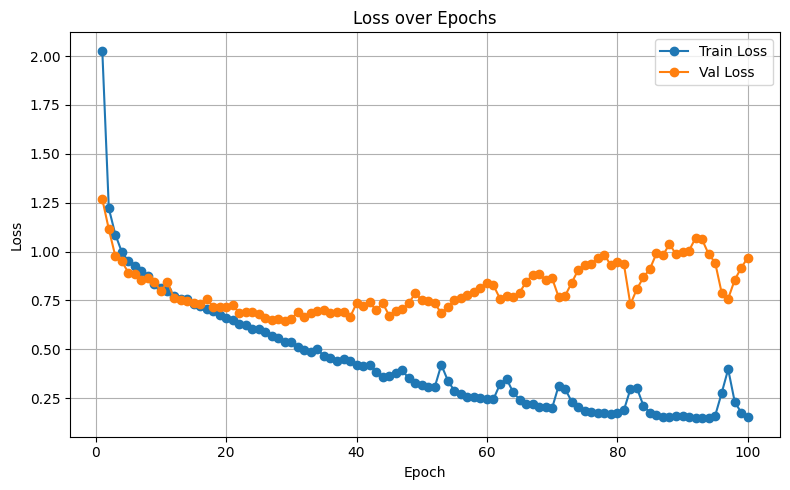

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

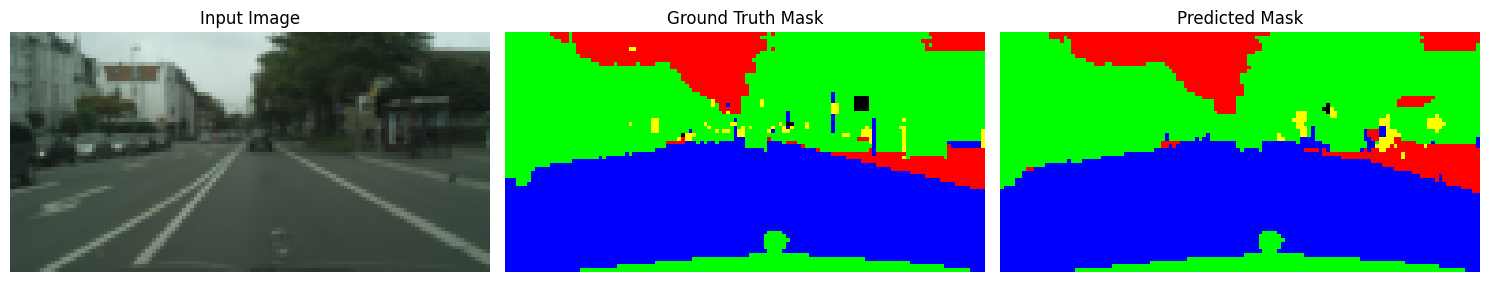

In [6]:
import numpy as np
import torch

model.eval()
with torch.no_grad():
    sample_image, sample_target = next(iter(val_loader))
    sample_image = sample_image.to(device)
    sample_target = sample_target.to(device)

    output = model(sample_image)
    pred_mask = torch.argmax(output, dim=1)

img = sample_image[0].cpu().permute(1, 2, 0).numpy()
gt_mask = sample_target[0].cpu().squeeze().numpy()
pred_mask = pred_mask[0].cpu().numpy()

def apply_colormap(mask):
    colormap = np.array([
        [0, 0, 0],         # class 0: black
        [0, 255, 0],       # class 1: green
        [0, 0, 255],       # class 2: blue
        [255, 0, 0],       # class 3: red
        [255, 255, 0],     # etc.
    ])
    mask_rgb = colormap[mask % len(colormap)]
    return mask_rgb.astype(np.uint8)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(img)
axs[0].set_title("Input Image")
axs[1].imshow(apply_colormap(gt_mask))
axs[1].set_title("Ground Truth Mask")
axs[2].imshow(apply_colormap(pred_mask))
axs[2].set_title("Predicted Mask")

for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [7]:
torch.save(model.state_dict(), "./weights/cityscapes_unet.pth")

# Ensemble

In [8]:
num_classes = 34

model1 = UNet(in_channels=3, out_channels=num_classes).to(device)
model2 = UNet(in_channels=3, out_channels=num_classes).to(device)
model3 = UNet(in_channels=3, out_channels=num_classes).to(device)

ensemble_models = [model1, model2, model3]

In [9]:
optimizer1 = torch.optim.Adam(model1.parameters(), lr=1e-3)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=1e-3)
optimizer3 = torch.optim.Adam(model3.parameters(), lr=1e-3)

ensemble_optimizers = [optimizer1, optimizer2, optimizer3]

In [10]:
from tqdm import tqdm

def train_one_epoch_ensemble(models, optimizers, loader, criterion):
    for model in models:
        model.train()

    total_loss = 0

    for images, targets in tqdm(loader, desc="Training"):
        images = images.to(device)
        targets = targets.to(device).long().squeeze(1)

        batch_loss = 0

        for model, optimizer in zip(models, optimizers):
            outputs = model(images)
            loss = criterion(outputs, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_loss += loss.item()

        total_loss += batch_loss / len(models)  # Average loss over ensemble

    return total_loss / len(loader)


def validate_ensemble(models, loader, criterion):
    for model in models:
        model.eval()

    total_loss = 0

    with torch.no_grad():
        for images, targets in loader:
            images = images.to(device)
            targets = targets.to(device).long().squeeze(1)

            outputs = [torch.softmax(model(images), dim=1) for model in models]
            avg_output = torch.stack(outputs).mean(dim=0)

            loss = criterion(avg_output, targets)
            total_loss += loss.item()

    return total_loss / len(loader)

In [11]:
num_epochs = 50
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    train_loss = train_one_epoch_ensemble(ensemble_models, ensemble_optimizers, train_loader, criterion)
    val_loss = validate_ensemble(ensemble_models, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")


Epoch 1/50


Training: 100%|██████████| 200/200 [01:24<00:00,  2.36it/s]


Train Loss: 2.1971 | Val Loss: 3.0860

Epoch 2/50


Training: 100%|██████████| 200/200 [01:24<00:00,  2.37it/s]


Train Loss: 1.2101 | Val Loss: 3.0214

Epoch 3/50


Training: 100%|██████████| 200/200 [01:24<00:00,  2.37it/s]


Train Loss: 1.0994 | Val Loss: 2.9823

Epoch 4/50


Training: 100%|██████████| 200/200 [01:24<00:00,  2.37it/s]


Train Loss: 1.0348 | Val Loss: 3.0204

Epoch 5/50


Training: 100%|██████████| 200/200 [01:24<00:00,  2.37it/s]


Train Loss: 0.9677 | Val Loss: 3.0036

Epoch 6/50


Training: 100%|██████████| 200/200 [01:24<00:00,  2.37it/s]


Train Loss: 0.9281 | Val Loss: 2.9343

Epoch 7/50


Training: 100%|██████████| 200/200 [01:24<00:00,  2.37it/s]


Train Loss: 0.8855 | Val Loss: 2.9010

Epoch 8/50


Training: 100%|██████████| 200/200 [01:24<00:00,  2.37it/s]


Train Loss: 0.8585 | Val Loss: 2.9276

Epoch 9/50


Training: 100%|██████████| 200/200 [01:24<00:00,  2.37it/s]


Train Loss: 0.8343 | Val Loss: 2.8927

Epoch 10/50


Training: 100%|██████████| 200/200 [01:24<00:00,  2.37it/s]


Train Loss: 0.8052 | Val Loss: 2.8775

Epoch 11/50


Training: 100%|██████████| 200/200 [01:24<00:00,  2.37it/s]


Train Loss: 0.7904 | Val Loss: 2.8915

Epoch 12/50


Training: 100%|██████████| 200/200 [01:24<00:00,  2.37it/s]


Train Loss: 0.7695 | Val Loss: 2.8733

Epoch 13/50


Training: 100%|██████████| 200/200 [01:24<00:00,  2.37it/s]


Train Loss: 0.7577 | Val Loss: 2.8702

Epoch 14/50


Training: 100%|██████████| 200/200 [01:24<00:00,  2.36it/s]


Train Loss: 0.7351 | Val Loss: 2.8712

Epoch 15/50


Training: 100%|██████████| 200/200 [01:24<00:00,  2.37it/s]


Train Loss: 0.7271 | Val Loss: 2.8675

Epoch 16/50


Training: 100%|██████████| 200/200 [01:24<00:00,  2.37it/s]


Train Loss: 0.6999 | Val Loss: 2.8468

Epoch 17/50


Training: 100%|██████████| 200/200 [01:24<00:00,  2.37it/s]


Train Loss: 0.6903 | Val Loss: 2.8526

Epoch 18/50


Training: 100%|██████████| 200/200 [01:24<00:00,  2.36it/s]


Train Loss: 0.6719 | Val Loss: 2.8961

Epoch 19/50


Training: 100%|██████████| 200/200 [01:24<00:00,  2.37it/s]


Train Loss: 0.6567 | Val Loss: 2.8386

Epoch 20/50


Training: 100%|██████████| 200/200 [01:24<00:00,  2.37it/s]


Train Loss: 0.6381 | Val Loss: 2.8366

Epoch 21/50


Training: 100%|██████████| 200/200 [01:24<00:00,  2.36it/s]


Train Loss: 0.6254 | Val Loss: 2.8371

Epoch 22/50


Training: 100%|██████████| 200/200 [01:24<00:00,  2.37it/s]


Train Loss: 0.6135 | Val Loss: 2.8333

Epoch 23/50


Training: 100%|██████████| 200/200 [01:24<00:00,  2.37it/s]


Train Loss: 0.5956 | Val Loss: 2.8209

Epoch 24/50


Training: 100%|██████████| 200/200 [01:24<00:00,  2.37it/s]


Train Loss: 0.5886 | Val Loss: 2.8229

Epoch 25/50


Training: 100%|██████████| 200/200 [01:24<00:00,  2.37it/s]


Train Loss: 0.5725 | Val Loss: 2.8280

Epoch 26/50


Training: 100%|██████████| 200/200 [01:24<00:00,  2.37it/s]


Train Loss: 0.5695 | Val Loss: 2.8257

Epoch 27/50


Training: 100%|██████████| 200/200 [01:24<00:00,  2.37it/s]


Train Loss: 0.5465 | Val Loss: 2.8067

Epoch 28/50


Training: 100%|██████████| 200/200 [01:24<00:00,  2.37it/s]


Train Loss: 0.5412 | Val Loss: 2.8240

Epoch 29/50


Training: 100%|██████████| 200/200 [01:24<00:00,  2.37it/s]


Train Loss: 0.5268 | Val Loss: 2.8061

Epoch 30/50


Training: 100%|██████████| 200/200 [01:24<00:00,  2.36it/s]


Train Loss: 0.5101 | Val Loss: 2.8014

Epoch 31/50


Training: 100%|██████████| 200/200 [01:24<00:00,  2.36it/s]


Train Loss: 0.5215 | Val Loss: 2.8149

Epoch 32/50


Training: 100%|██████████| 200/200 [01:24<00:00,  2.37it/s]


Train Loss: 0.4996 | Val Loss: 2.8153

Epoch 33/50


Training: 100%|██████████| 200/200 [01:24<00:00,  2.37it/s]


Train Loss: 0.4717 | Val Loss: 2.8047

Epoch 34/50


Training: 100%|██████████| 200/200 [01:24<00:00,  2.37it/s]


Train Loss: 0.4617 | Val Loss: 2.7963

Epoch 35/50


Training: 100%|██████████| 200/200 [01:24<00:00,  2.37it/s]


Train Loss: 0.4506 | Val Loss: 2.8013

Epoch 36/50


Training: 100%|██████████| 200/200 [01:24<00:00,  2.37it/s]


Train Loss: 0.4496 | Val Loss: 2.7971

Epoch 37/50


Training: 100%|██████████| 200/200 [01:24<00:00,  2.37it/s]


Train Loss: 0.4466 | Val Loss: 2.8011

Epoch 38/50


Training: 100%|██████████| 200/200 [01:24<00:00,  2.37it/s]


Train Loss: 0.4442 | Val Loss: 2.7968

Epoch 39/50


Training: 100%|██████████| 200/200 [01:24<00:00,  2.37it/s]


Train Loss: 0.4281 | Val Loss: 2.7971

Epoch 40/50


Training: 100%|██████████| 200/200 [01:24<00:00,  2.37it/s]


Train Loss: 0.4141 | Val Loss: 2.7937

Epoch 41/50


Training: 100%|██████████| 200/200 [01:24<00:00,  2.37it/s]


Train Loss: 0.4019 | Val Loss: 2.7943

Epoch 42/50


Training: 100%|██████████| 200/200 [01:24<00:00,  2.37it/s]


Train Loss: 0.3933 | Val Loss: 2.7858

Epoch 43/50


Training: 100%|██████████| 200/200 [01:24<00:00,  2.37it/s]


Train Loss: 0.3837 | Val Loss: 2.7954

Epoch 44/50


Training: 100%|██████████| 200/200 [01:24<00:00,  2.37it/s]


Train Loss: 0.3774 | Val Loss: 2.7789

Epoch 45/50


Training: 100%|██████████| 200/200 [01:24<00:00,  2.37it/s]


Train Loss: 0.3720 | Val Loss: 2.7897

Epoch 46/50


Training: 100%|██████████| 200/200 [01:24<00:00,  2.37it/s]


Train Loss: 0.3574 | Val Loss: 2.7856

Epoch 47/50


Training: 100%|██████████| 200/200 [01:24<00:00,  2.37it/s]


Train Loss: 0.3408 | Val Loss: 2.7829

Epoch 48/50


Training: 100%|██████████| 200/200 [01:24<00:00,  2.37it/s]


Train Loss: 0.3662 | Val Loss: 2.7936

Epoch 49/50


Training: 100%|██████████| 200/200 [01:24<00:00,  2.37it/s]


Train Loss: 0.3383 | Val Loss: 2.7763

Epoch 50/50


Training: 100%|██████████| 200/200 [01:24<00:00,  2.37it/s]


Train Loss: 0.3193 | Val Loss: 2.7830


In [12]:
for i, model in enumerate(ensemble_models):
    torch.save(model.state_dict(), f"./weights/cityscapes_ensemble_unet_{i+1}.pth")